<a href="https://colab.research.google.com/github/Maviya5/CE888/blob/master/assignment/Santander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

In [25]:
import os

os.environ['KAGGLE_USERNAME'] = "maviya" # username from the json file

os.environ['KAGGLE_KEY'] = "c861551424149b9beab35c71e8c40078" # key from the json file

!kaggle competitions download -c santander-customer-transaction-prediction # api copied from kaggle

 

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

Loading of the data


In [27]:
#Zip file
from zipfile import ZipFile
file_name = "train.csv.zip"
file_name = "test.csv.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
train = pd.read_csv('train.csv', low_memory=True)
test = pd.read_csv('test.csv', low_memory=True)

In [29]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


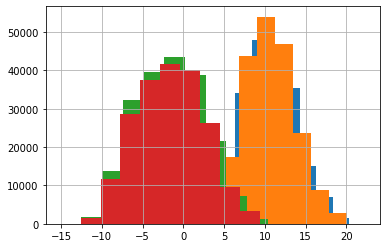

In [30]:
train["var_0"].hist() 
test['var_0'].hist()
train["var_1"].hist() 
test['var_1'].hist()

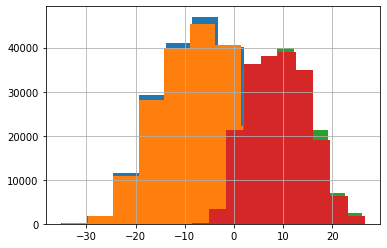

In [31]:
train["var_40"].hist() 
test['var_40'].hist()
train["var_41"].hist() 
test['var_41'].hist()

In [32]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [33]:
print('train shape:', train.shape)
print('test shape:',test.shape)

train shape: (200000, 202)
test shape: (200000, 201)


In [0]:
#dropping target since it is not there in test and ID_code is not important information
train.drop(columns=['ID_code','target'], inplace=True)
test.drop(columns=['ID_code'], inplace=True)

In [35]:
print(train)

          var_0   var_1    var_2   var_3  ...  var_196  var_197  var_198  var_199
0        8.9255 -6.7863  11.9081  5.0930  ...   7.8784   8.5635  12.7803  -1.0914
1       11.5006 -4.1473  13.8588  5.3890  ...   8.1267   8.7889  18.3560   1.9518
2        8.6093 -2.7457  12.0805  7.8928  ...  -6.5213   8.2675  14.7222   0.3965
3       11.0604 -2.1518   8.9522  7.1957  ...  -2.9275  10.2922  17.9697  -8.9996
4        9.8369 -1.4834  12.8746  6.6375  ...   3.9267   9.5031  17.9974  -8.8104
...         ...     ...      ...     ...  ...      ...      ...      ...      ...
199995  11.4880 -0.4956   8.2622  3.5142  ...   2.1661   8.5326  16.6660 -17.8661
199996   4.9149 -2.4484  16.7052  6.6345  ...  -2.1651   6.7419  15.9054   0.3388
199997  11.2232 -5.0518  10.5127  5.6456  ...   1.2832   8.7155  13.8329   4.1995
199998   9.7148 -8.6098  13.6104  5.7930  ...   6.7980  10.0342  15.5289 -13.9001
199999  10.8762 -5.7105  12.1183  8.0328  ...  -2.2342   8.1857  12.1284   0.1385

[200000 rows x 

In [36]:
print(test)

          var_0    var_1    var_2   var_3  ...  var_196  var_197  var_198  var_199
0       11.0656   7.7798  12.9536  9.4292  ...   4.3654  10.7200  15.4722  -8.7197
1        8.5304   1.2543  11.3047  5.1858  ...  -1.4852   9.8714  19.1293 -20.9760
2        5.4827 -10.3581  10.1407  7.0479  ...  -7.1086   7.0618  19.8956 -23.1794
3        8.5374  -1.3222  12.0220  6.5749  ...   3.9567   9.2295  13.0168  -4.2108
4       11.7058  -0.1327  14.1295  7.7506  ...  -5.1612   7.2882  13.9260  -9.1846
...         ...      ...      ...     ...  ...      ...      ...      ...      ...
199995  13.1678   1.0136  10.4333  6.7997  ...  -4.6195   9.1568  18.2102   4.8801
199996   9.7171  -9.1462   7.3443  9.1421  ...   2.9995   9.1112  18.1740 -20.7689
199997  11.6360   2.2769  11.2074  7.7649  ...  -4.1524   9.1933  11.7905 -22.2762
199998  13.5745  -0.5134  13.6584  7.4855  ...  -2.3761   8.1079   8.7735  -0.2122
199999  10.4664   1.8070  10.2277  6.0654  ...  -2.5981  10.3378  14.3340  -7.7094

[20

In [0]:
#addind a column to identify if a row comes from train or test
test['is_train'] = 1
train['is_train'] = 0 

In [39]:
from sklearn.model_selection import train_test_split
#concatenating test and train data
df_combine = pd.concat([train, test], axis=0, ignore_index=True)
y = df_combine['is_train'].values #labels
X = df_combine.drop('is_train', axis=1).values #covariates or our independent variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
print('set2 train shape:', X_train.shape, 'set2 test shape:', X_test.shape)

set2 train shape: (280000, 200) set2 test shape: (120000, 200)


In [40]:
print('y_test shape:', y_test.shape, 'y_train shape:', y_train.shape)

y_test shape: (120000,) y_train shape: (280000,)


In [0]:
clf = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)

In [0]:
clf.fit(X_train, y_train)
probs_y_test = clf.predict(X_test) #calculating the predictions

In [0]:
from sklearn.metrics import roc_auc_score as AUC


In [59]:
print('ROC-AUC for train and test distributions:', round(AUC(y_true=y_test, y_score=probs_y_test[:,]), 4))

ROC-AUC for train and test distributions: 0.5088


Since the AUC-ROC score is around 0.50 it can be said that it failed to achieve covariate shift.